# Modelo de Clasificación PQR nivel 2

Teniendo en cuenta que ya se tiene un primer nivel de clasificación entre PQR, ahora se pretende clasificar por cada tipo de PQR. A esto le llamamos nivel 2 de clasificación. 
Este libro aborda el preprocesamiento, y el entrenamiento de un modelo de clasificación para PQRs en el nivel 2

Para este paso se tendrá en cuenta las siguientes prioridades por tipo de PQR:

* Peticiones: emisión de documento para pago
* Pedidos/Proyectos: conexión del servicio
* Reclamos: inconformidad con el consumo o producción factura
* Quejas: entrega inoportuna o no entrega de la factura
* Recursos: inconformidad con el consumo o producción facturad

In [1]:
## importamos las librerias
##
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
datos_md = pd.read_csv('PQR_modelo.csv', encoding='utf-8')
datos_md.head()

,tipo_solicitud,tipo_solicitud_1,OBSERVACION USUARIO
0,peticion,pago parcial,solicita pago parcial facturado
1,peticion,emision de documento para pago,cliente solicita copia factura
2,peticion,emision de documento para pago,cliente solicita copia factura
3,peticion,pago parcial,solicita pago parcial facturado
4,peticion,emision de documento para pago,cliente solicita copia factura


In [3]:
len(datos_md)

453729

In [4]:
for t in datos_md['tipo_solicitud'].unique():
    print(t+'\n')
    print(datos_md[datos_md['tipo_solicitud']==t]['tipo_solicitud_1'].value_counts())
    print('\n')

peticion

emision de documento para pago                                      156593
pago parcial                                                        134347
separacion temporal o pago dirigido                                  30676
trabajos tecnicos en med, trafos, acometidas o en infraestr.         20001
datos basicos                                                        17596
gestionar financiacion                                               15991
reconexion                                                           13810
descongelados covid-19                                               11054
informacion general                                                   9138
exencion contribucion                                                 2640
notificacion decision y/o descargos                                   2178
inscripcion, retiro o bloqueo de tarjeta pfs                           902
poda de arboles                                                        762
cambio de plazo

## Peticiones
### Exploración y Preprocesamiento 

En esta primera sección se explorará el set de peticiones y se preprocesarán los textos con los cuales se entrenará el modelo de peticiones

In [5]:
'''a = datos_md[datos_md['tipo_solicitud']=='peticion'][['tipo_solicitud_1', 'OBSERVACION USUARIO']]
d = dict(datos_md[datos_md['tipo_solicitud']=='peticion']['tipo_solicitud_1'].value_counts())

for index, item in enumerate(a['tipo_solicitud_1']):
    if item not in ['emision de documento para pago', 'pago parcial']:
        a[index] = 'otro'
print(a['tipo_solicitud_1'].value_counts())'''

"a = datos_md[datos_md['tipo_solicitud']=='peticion'][['tipo_solicitud_1', 'OBSERVACION USUARIO']]\nd = dict(datos_md[datos_md['tipo_solicitud']=='peticion']['tipo_solicitud_1'].value_counts())\n\nfor index, item in enumerate(a['tipo_solicitud_1']):\n    if item not in ['emision de documento para pago', 'pago parcial']:\n        a[index] = 'otro'\nprint(a['tipo_solicitud_1'].value_counts())"

In [6]:
a = datos_md[datos_md['tipo_solicitud']=='peticion'][['tipo_solicitud_1', 'OBSERVACION USUARIO']]
a['tipo_solicitud_1'] = a['tipo_solicitud_1'].map(lambda x: 'otro' if x not in ['emision de documento para pago', 'pago parcial'] else x)
print(a['tipo_solicitud_1'].value_counts())

emision de documento para pago    156593
pago parcial                      134347
otro                              131699
Name: tipo_solicitud_1, dtype: int64


In [7]:
'''temp = a[a['tipo_solicitud_1']=='otro']['tipo_solicitud_1']
indexes = temp.index
index_sample = random.sample(list(indexes), len(temp)-130)
a.drop(index_sample, inplace=True)
a['tipo_solicitud_1'].value_counts()'''

"temp = a[a['tipo_solicitud_1']=='otro']['tipo_solicitud_1']\nindexes = temp.index\nindex_sample = random.sample(list(indexes), len(temp)-130)\na.drop(index_sample, inplace=True)\na['tipo_solicitud_1'].value_counts()"

In [8]:
possible_labels = a['tipo_solicitud_1'].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
a['tipo_sol_1_int'] = a['tipo_solicitud_1'].replace(label_dict)

In [9]:
len(a)

422639

La fase de exploración dejó como resultado una depuración de categorías que tenían muy pocos registros, contando con un total de 3 tipos de solicitud nivel 1 y 422639 registros. Yo pienso que deben haber muchas menos categorias por ahora, esto tendría que depurarse con base al pareto de las peticiones.

### Entrenamiento del modelo de peticiones

In [10]:
## Acá se entrena una SVC con kernel lineal.
##
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

x = a['OBSERVACION USUARIO']
y = a['tipo_solicitud_1']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2022021, stratify=a['tipo_solicitud_1'])

peticion_clf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.90, min_df=10)),
                         ('svd', TruncatedSVD(n_components=200)),
                         ('svm', LinearSVC(C=10, random_state=1022021, max_iter=2000))])
#peticion_clf = Pipeline([('tfidf', TfidfVectorizer()), ('scl', preprocessing.StandardScaler(with_mean=False)),
#                         ('svm', SVC(C=10, kernel='rbf', random_state=10022021, max_iter=2000))])

train_acc = peticion_clf.fit(x_train, y_train).score(x_train, y_train)
print(f"El accuracy en entrenamiento es de {round(train_acc, 3)}")

El accuracy en entrenamiento es de 0.974


In [11]:
from sklearn import metrics

predictions = peticion_clf.predict(x_test)
test_acc = metrics.accuracy_score(y_test, predictions)

print(f"El accuracy en validación es de {round(test_acc, 3)} (dif: {round((train_acc-test_acc)*100, 2)}%)")
if train_acc-test_acc > 0.10:
    print("Warning: peligro de sobre-entrenamiento")

El accuracy en validación es de 0.973 (dif: 0.09%)


Precisión del clasificador: 97.32 

Matriz de Confusión: 
 [[50833   655   188]
 [   29 42370  1062]
 [    8  1790 42536]]


<AxesSubplot:>

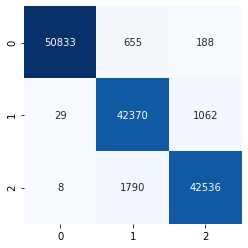

In [12]:
import seaborn as sns

#Calculamos la precisión y mostramos la matriz de confusión
acc = metrics.accuracy_score(y_test, predictions)
mat = metrics.confusion_matrix(y_test, predictions)

print ("Precisión del clasificador: %.2f " %(acc*100.0) )
print ("\nMatriz de Confusión: \n", mat)

#Esta es otra forma de ver la matriz de confusión
sns.heatmap(mat, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")

In [13]:
print(metrics.classification_report(y_test, predictions))

                                precision    recall  f1-score   support

emision de documento para pago       1.00      0.98      0.99     51676
                          otro       0.95      0.97      0.96     43461
                  pago parcial       0.97      0.96      0.97     44334

                      accuracy                           0.97    139471
                     macro avg       0.97      0.97      0.97    139471
                  weighted avg       0.97      0.97      0.97    139471



In [14]:
## Validación cruzada.
#
'''from sklearn import model_selection
x_train_tfidf = TfidfVectorizer(max_df=0.90, min_df=10).fit_transform(x_train)

x_train_tfidf = TruncatedSVD(n_components=200).fit_transform(x_train_tfidf)

kfold = model_selection.StratifiedKFold(n_splits=10000)
score = model_selection.cross_val_score(LinearSVC(C=10, random_state=1022021, max_iter=2000), x_train_tfidf, y_train, cv=kfold, scoring='accuracy')
#score = model_selection.cross_val_score(SVC(C=10, kernel='rbf', random_state=10022021, max_iter=5000), x_train_tfidf, y_train, cv=kfold, scoring='accuracy')
print(f"Accuracy: {round(score.mean()*100, 2)} (+/-{round(score.std()*100, 2)})")'''

'from sklearn import model_selection\nx_train_tfidf = TfidfVectorizer(max_df=0.90, min_df=10).fit_transform(x_train)\n\nx_train_tfidf = TruncatedSVD(n_components=200).fit_transform(x_train_tfidf)\n\nkfold = model_selection.StratifiedKFold(n_splits=10000)\nscore = model_selection.cross_val_score(LinearSVC(C=10, random_state=1022021, max_iter=2000), x_train_tfidf, y_train, cv=kfold, scoring=\'accuracy\')\n#score = model_selection.cross_val_score(SVC(C=10, kernel=\'rbf\', random_state=10022021, max_iter=5000), x_train_tfidf, y_train, cv=kfold, scoring=\'accuracy\')\nprint(f"Accuracy: {round(score.mean()*100, 2)} (+/-{round(score.std()*100, 2)})")'

In [15]:
M = TfidfVectorizer(max_df=0.90, min_df=10).fit_transform(a['OBSERVACION USUARIO'])
M.shape

(422639, 3763)

In [16]:
from sklearn.preprocessing import label_binarize

label_binarize(a['tipo_sol_1_int'], classes=[0,1,2])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

Average precision score, micro-averaged over all classes: 1.00


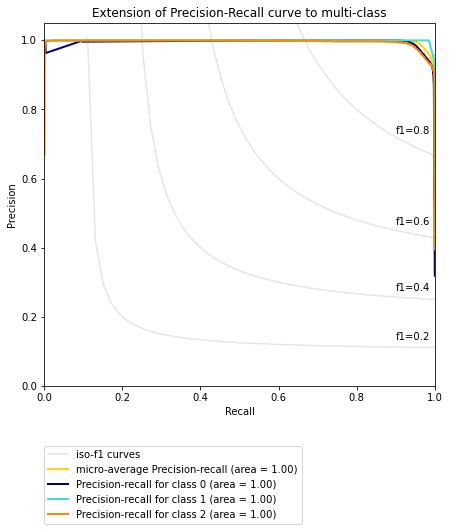

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

x = TfidfVectorizer(max_df=0.90, min_df=10).fit_transform(a['OBSERVACION USUARIO'])
x = TruncatedSVD(n_components=200).fit_transform(x)

y = label_binarize(a['tipo_sol_1_int'], classes=[0,1,2])
n_classes = 3

# shuffle and split training and test sets
x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.33, random_state=0, stratify=y)

# ROC y AUC solo sirven en espacios de clasificacion binarios, por esta razon se 
# entrena un clasificador binario uno vs todos
clf = OneVsRestClassifier(LinearSVC(C=10, random_state=1022021, max_iter=2000))
#clf = OneVsRestClassifier(SVC(C=10, kernel='rbf', random_state=10022021, max_iter=5000))
y_score = clf.fit(x_train, y_train).decision_function(x_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))


plt.show()

In [18]:
exec(open('text_nomalization.py', 'rb').read())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
text_normalization('este es un texto de prueba que estoy escribiendo porque quiero ver si funciona la fíncíón')

'texto prueba escribiendo quiero ver si funciona fíncíón'

In [20]:
## Ensayo
text_ensayo = text_normalization('Buenas, esque quiero saber si me pueden enviar una copia de la factura porque como le parece que a mi marido se le mojó')
text_ensayo

'buenas esque quiero saber si pueden enviar copia factura parece marido mojó'

In [21]:
peticion_clf.predict([text_ensayo])

array(['emision de documento para pago'], dtype=object)

## Reclamo

En esta primera sección se explorará el set de peticiones y se preprocesarán los textos con los cuales se entrenará el modelo de peticiones

In [22]:
a = datos_md[datos_md['tipo_solicitud']=='reclamo'][['tipo_solicitud_1', 'OBSERVACION USUARIO']]
a['tipo_solicitud_1'] = a['tipo_solicitud_1'].map(lambda x: 'otro' if x != 'inconformidad con el consumo o produccion facturad' else x)
print(a['tipo_solicitud_1'].value_counts())

inconformidad con el consumo o produccion facturad    19295
otro                                                   1950
Name: tipo_solicitud_1, dtype: int64


In [23]:
temp = a[a['tipo_solicitud_1']=='inconformidad con el consumo o produccion facturad']['tipo_solicitud_1']
indexes = temp.index
index_sample = random.sample(list(indexes), len(temp)-1950)
a.drop(index_sample, inplace=True)
a['tipo_solicitud_1'].value_counts()

otro                                                  1950
inconformidad con el consumo o produccion facturad    1950
Name: tipo_solicitud_1, dtype: int64

In [24]:
possible_labels = a['tipo_solicitud_1'].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
a['tipo_sol_1_int'] = a['tipo_solicitud_1'].replace(label_dict)

In [25]:
len(a)

3900

### Entrenamiento del modelo de Reclamos